<a href="https://colab.research.google.com/github/woneuy01/NLP_Jon/blob/master/conv_lstm_stack_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvNet-LSTM Stack Sentiment Classifier

In this notebook, we stack an LSTM on top of a convolutional layer to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [0]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [0]:
# output directory name:
output_dir = 'model_output/cnnLSTM'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv = 64  
k_conv = 3 
mp_size = 4

# LSTM layer architecture:
n_lstm = 64 
drop_lstm = 0.2

#### Load data

In [0]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

17465344/17464789 [==============================] - 0s 0us/step


#### Preprocess data

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [0]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [0]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 718,529
Trainable params: 718,529
Non-trainable params: 0
__________________________________________________

#### Configure model

In [0]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 6s 30ms/step - loss: 0.4634 - accuracy: 0.7579 - val_loss: 0.3138 - val_accuracy: 0.8680
Epoch 2/4
196/196 [==============================] - 5s 26ms/step - loss: 0.2467 - accuracy: 0.9022 - val_loss: 0.3000 - val_accuracy: 0.8754
Epoch 3/4
196/196 [==============================] - 5s 26ms/step - loss: 0.1876 - accuracy: 0.9300 - val_loss: 0.3480 - val_accuracy: 0.8577
Epoch 4/4
196/196 [==============================] - 5s 26ms/step - loss: 0.1435 - accuracy: 0.9485 - val_loss: 0.3552 - val_accuracy: 0.8628


#### Evaluate

In [0]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [0]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


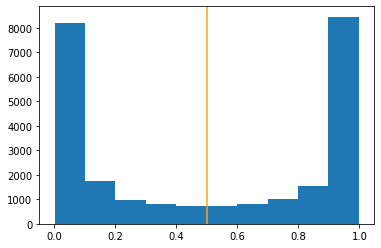

In [0]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [0]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.64'